In [2]:
import numpy as np
import pandas as pd

# Assumes df includes engineered features from Step 2:
# ['step','type','amount','Day','Hour','IsNight','LogAmount',
#  'DailyTxnCount','OrigTxnCount','DestTxnCount','TxnCountWindow',
#  'RuleHighValue','RuleRapidFire','Type_encoded','isFraud']
# and that Step 3 produced X, y, X_train, X_test, y_train, y_test, hybrid_score, y_pred_alert

# -------------------------------
# 1. Baseline profiles (origin and destination)
# -------------------------------

df = pd.read_csv("C:\\Users\\naman\\PaySafe UPI Fraud Detection\\Data\\cleaned_Data.csv")

# Origin (nameOrig) baselines
orig_profile = df.groupby('nameOrig').agg(
    mean_amount=('amount', 'mean'),
    std_amount=('amount', 'std'),
    median_amount=('amount', 'median'),
    mean_hour=('Hour', 'mean'),
    night_rate=('IsNight', 'mean'),
    txn_per_day_mean=('DailyTxnCount', 'mean'),
    txn_per_day_std=('DailyTxnCount', 'std'),
).fillna(0).reset_index()

# Destination (nameDest) baselines
dest_profile = df.groupby('nameDest').agg(
    dest_mean_amount=('amount', 'mean'),
    dest_std_amount=('amount', 'std'),
    dest_median_amount=('amount', 'median'),
    dest_night_rate=('IsNight', 'mean'),
    dest_txn_count=('DestTxnCount', 'mean'),
).fillna(0).reset_index()

# -------------------------------
# 2. Attach profiles to the full dataframe
# -------------------------------
df_bp = df.merge(orig_profile, on='nameOrig', how='left').merge(dest_profile, on='nameDest', how='left')

# -------------------------------
# 3. Deviation and risk signals
# -------------------------------
# Z-score deviation from origin baseline
df_bp['amount_z_orig'] = (df_bp['amount'] - df_bp['mean_amount']) / (df_bp['std_amount'] + 1e-9)

# Robust deviation from destination median
df_bp['amount_dev_dest'] = (df_bp['amount'] - df_bp['dest_median_amount']) / (df_bp['dest_std_amount'] + 1e-9)

# Night behavior deviation
df_bp['night_dev_orig'] = df_bp['IsNight'] - df_bp['night_rate']

# Burstiness vs personal norm
df_bp['burst_dev'] = (df_bp['TxnCountWindow'] - df_bp['txn_per_day_mean']) / (df_bp['txn_per_day_std'] + 1e-9)

# Simple behavior risk score (bounded 0–1)
risk_components = (
    np.clip(np.abs(df_bp['amount_z_orig']), 0, 5)/5 +
    np.clip(np.abs(df_bp['amount_dev_dest']), 0, 5)/5 +
    np.clip(np.abs(df_bp['burst_dev']), 0, 5)/5 +
    df_bp['RuleHighValue']*0.5 +
    df_bp['RuleRapidFire']*0.5
)
df_bp['BehaviorRisk'] = np.clip(risk_components / 3.0, 0, 1)

# -------------------------------
# 4. Prepare behavior features for modeling
# -------------------------------

# Recreate X and y if not already defined
feature_cols = [
    'amount','LogAmount','Hour','IsNight','DailyTxnCount',
    'OrigTxnCount','DestTxnCount','TxnCountWindow',
    'RuleHighValue','RuleRapidFire','Type_encoded'
]

X = df[feature_cols].copy()
y = df['isFraud'].astype(int)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


behavior_features = [
    'amount_z_orig', 'amount_dev_dest', 'night_dev_orig', 'burst_dev', 'BehaviorRisk'
]

# Align with X indices to avoid leakage/misalignment
bp_for_X = df_bp.loc[X.index, behavior_features].copy()

# -------------------------------
# 5. Extend feature matrix with behavior profiling
# -------------------------------
X_bp = pd.concat([X, bp_for_X], axis=1)

print("Behavior profiling features added:", behavior_features)
print("New feature matrix shape:", X_bp.shape)

# Optional: if you want to re-train with behavior features
# Re-split to match earlier train/test indices
X_train_bp = X_bp.loc[X_train.index]
X_test_bp  = X_bp.loc[X_test.index]

Behavior profiling features added: ['amount_z_orig', 'amount_dev_dest', 'night_dev_orig', 'burst_dev', 'BehaviorRisk']
New feature matrix shape: (6362620, 16)


In [3]:
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier

# Scale only the new numeric behavior features if needed
from sklearn.preprocessing import StandardScaler
bp_numeric = ['amount_z_orig','amount_dev_dest','night_dev_orig','burst_dev','BehaviorRisk']
scaler_bp = StandardScaler()
X_train_bp[bp_numeric] = scaler_bp.fit_transform(X_train_bp[bp_numeric])
X_test_bp[bp_numeric]  = scaler_bp.transform(X_test_bp[bp_numeric])

# Isolation Forest on extended features
iso_bp = IsolationForest(
    contamination=0.01,
    n_estimators=100,
    random_state=42,
    n_jobs=-1
).fit(X_train_bp)

# XGBoost with class imbalance handling
pos = y_train.sum(); neg = len(y_train) - pos
scale_pos_weight = max(1.0, neg / max(1, pos))

xgb_bp = XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42
).fit(X_train_bp, y_train)

# Scores
xgb_prob_test_bp = xgb_bp.predict_proba(X_test_bp)[:, 1]
iso_score_raw_bp = -iso_bp.decision_function(X_test_bp)
iso_score_bp = (iso_score_raw_bp - iso_score_raw_bp.min()) / (iso_score_raw_bp.max() - iso_score_raw_bp.min() + 1e-9)

# Rule boost from existing columns
rule_boost_bp = 0.5*X_test_bp['RuleHighValue'].values + 0.5*X_test_bp['RuleRapidFire'].values
rule_boost_bp = np.clip(rule_boost_bp, 0, 1)

hybrid_score_bp = 0.6*xgb_prob_test_bp + 0.3*iso_score_bp + 0.1*rule_boost_bp
y_pred_alert_bp = (hybrid_score_bp >= 0.8).astype(int)

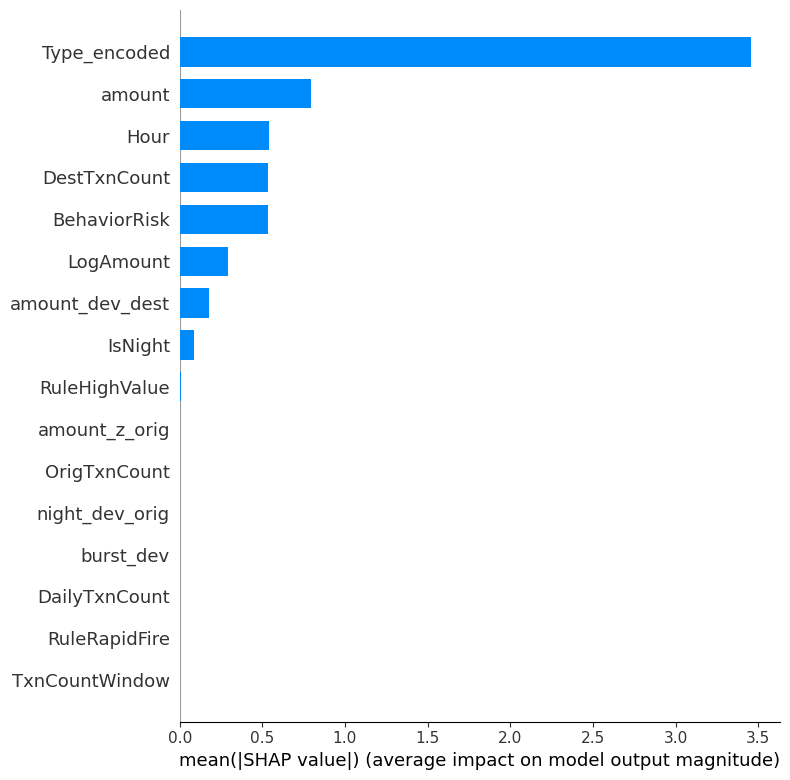

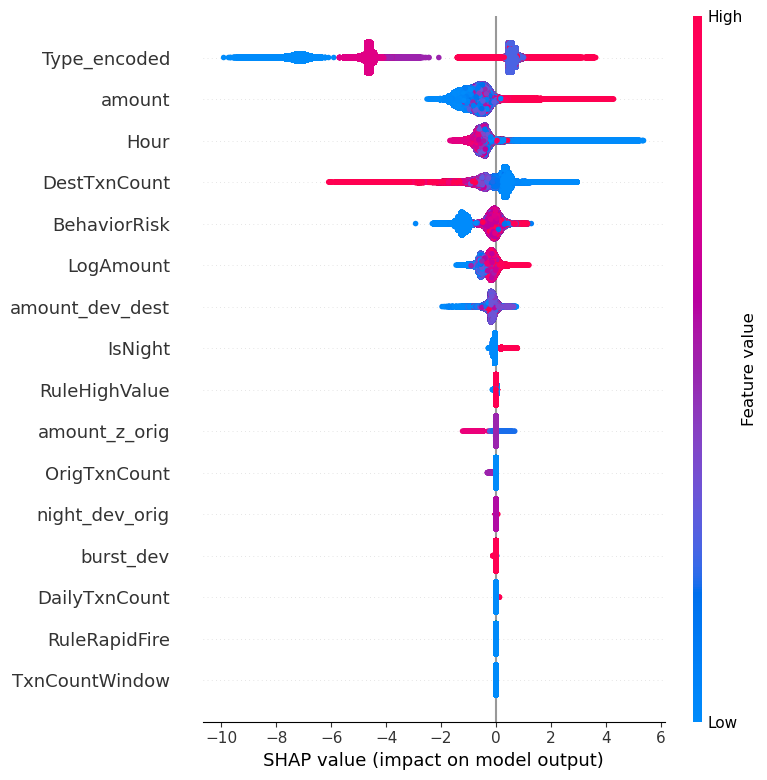

NameError: name 'explainer' is not defined

In [7]:

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TreeExplainer for the retrained XGBoost
explainer_bp = shap.TreeExplainer(xgb_bp)
shap_values_bp = explainer_bp.shap_values(X_test_bp)

# Global importance plots
shap.summary_plot(shap_values_bp, X_test_bp, plot_type="bar")
shap.summary_plot(shap_values_bp, X_test_bp)

# Save dashboard CSVs
# 1) Ranked global importance
shap_importance_bp = np.abs(shap_values_bp).mean(axis=0)
importance_bp_df = pd.DataFrame({
    "Feature": X_test_bp.columns,
    "MeanAbsSHAP": shap_importance_bp
}).sort_values("MeanAbsSHAP", ascending=False)
importance_bp_df.to_csv("C:/Users/naman/PaySafe UPI Fraud Detection/Models/shap_feature_importance_bp.csv", index=False)

# 2) Transaction-level SHAP with outcomes
shap_tx_bp = pd.DataFrame(shap_values_bp, columns=X_test_bp.columns, index=X_test_bp.index)
shap_tx_bp['HybridScore'] = hybrid_score_bp
shap_tx_bp['IsFraud'] = y_test.values
shap_tx_bp['Alert'] = y_pred_alert_bp
shap_tx_bp.to_csv("C:/Users/naman/PaySafe UPI Fraud Detection/Dashboard/shap_transaction_values_bp.csv", index=False)

# 3) Decision Plot for Transparency
shap.decision_plot(
    explainer.expected_value,
    shap_values[0,:],
    X_test.columns,
    feature_display_range=slice(None, 10)  # top 10 features
)

# 4) Fraud vs non-fraud averages
fraud_mean = shap_tx_bp[shap_tx_bp['IsFraud']==1][X_test_bp.columns].mean()
nonfraud_mean = shap_tx_bp[shap_tx_bp['IsFraud']==0][X_test_bp.columns].mean()
comparison_bp = pd.DataFrame({"FraudMeanSHAP": fraud_mean, "NonFraudMeanSHAP": nonfraud_mean})
comparison_bp.to_csv("C:/Users/naman/PaySafe UPI Fraud Detection/Dashboard/shap_fraud_vs_nonfraud_bp.csv")